# Workshop sur l’optimisation de portefeuille - Dim 5 nov - 10h

Ce document est un complément au workshop sur l'optimisation par la CDPQ. Il est destiné à vous outiller afin de concevoir le module qui vous permettra de
faire la sélection des titres et le balancement de votre portefeuille.

Les sujets abordés sont: 
- Modèle de Markowitz
- Modèles à facteurs (Fama French)

Pour chaque section, une capsule théorique ainsi que l'application de celle-ci via des librairies python vous serons fournis.

*Le jeu de données utilisé dans ce workhop est identique à celui du défis du datathon*
*Veuillez suivre les guides d'installation fourni pour faire le setup de ce worksop*


In [12]:
#!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn cvxopt plotly cufflinks


In [38]:
## NUMBER OF ASSETS
n_assets = 20

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)
R = np.asmatrix(np.mean(return_vec, axis=1))
print(R)

[[-0.01791875  0.02528007  0.07714924  0.0453157   0.06051267 -0.0145315
  -0.02982269 -0.01267858 -0.01366343 -0.00139905  0.02637161  0.0233492
  -0.01087319 -0.0552803   0.00646594  0.01596486  0.01834897 -0.03289558
   0.04102987  0.05859984]]


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import plotly
import cufflinks
import plotly.express as px

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

## Loading data

In [14]:
ROOT='./kaggle/input/dt23-test/' # remove the dot (.) for the kaggle version

In [24]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
adjusted_close = adjusted_close.dropna(axis=1).iloc[:, :20]

adjusted_close.shape

(6022, 20)

## Modèle de Markowitz

https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf

### Génération de portfolios non optimaux aléatoirement

Nous allons générer des portfolio non-optimal contenants les 20 premières actions de notre jeux de donnée, soit le S&P 500. Nous allons utiliser l'ensemble des observations de notre jeux pour chacun de ces actifs soit le prix de fermeture pour l'ensemble des 6022 jours.

Dans le code ci-dessous, nous créons un vecteur des rendements journaliers de chaque action. Nous représentant grapgiquement ceux-ci à travers le temps.


Text(0, 0.5, 'Rendement')

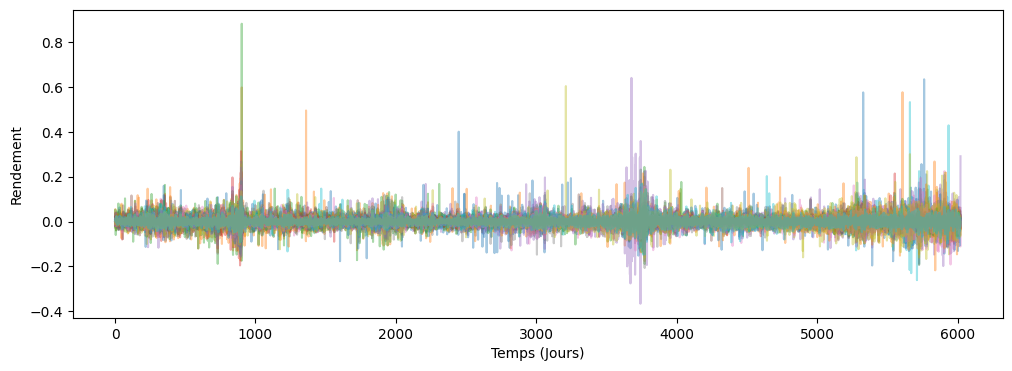

In [27]:
returns = adjusted_close.pct_change().dropna() # calcul rendement journalier
return_vec = returns.T.values

fig = plt.figure(figsize=(12,4))
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('Temps (Jours)') 
plt.ylabel('Rendement')

Nous allons maintenant gérérer 1000 portfolios avec des poids aléatoires tout en respectant notre facteur de risque arbitraire, soit que σ > 2.

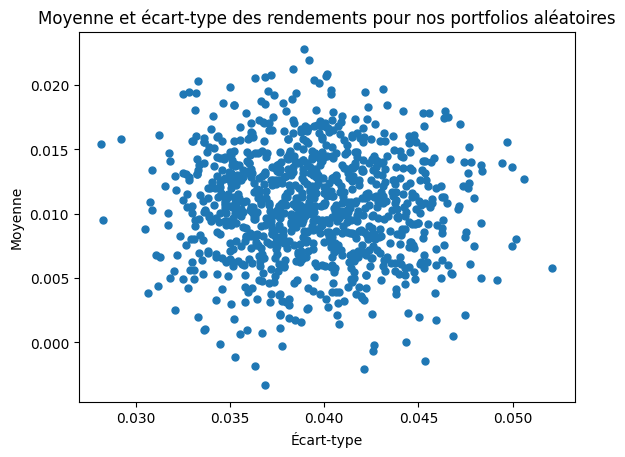

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def random_weights(n):
    """
        Retourne une liste de n poids dont la somme donne 1.
    """
    w_i = np.random.rand(n)
    return w_i / sum(w_i)

def random_portfolio(returns):
    """
        Retourne la moyenne et l'écart type du rendement de notre portfolio généré aléatoirement.
    """
    n_assets = returns.shape[0]  # Number of assets

    W = np.asmatrix(random_weights(n_assets)).T
    R = np.asmatrix(np.mean(returns, axis=1)).T
    COV = np.asmatrix(np.cov(returns))
    
    mu = W.T * R
    sigma = np.sqrt(W.T * COV * W)

    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_vec.T)
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('Écart-type')
plt.ylabel('Moyenne')
plt.title('Moyenne et écart-type des rendements pour nos portfolios aléatoires')
plt.show()


### Création du portefeuille optimale

Maintenant que nous avons vu le retour moyen  de nos portefolios aléatoires, touvons un portefolio optimal soit qui nous donne un meilleur rendement.
Nous cherchons a calculer notre frontière d'efficience en minimisant 

Pour traiter nos matrices, nous utiliserons la librairie CVXOPT (https://cvxopt.org/index.html) :
- blas: https://cvxopt.org/userguide/blas.html
- solvers: https://cvxopt.org/userguide/coneprog.html





Nous utiliserons le même modèle prédictif fourni dans le challenge pour prédire le rendement des actifs choisis.

Le modèle actuel est très simpliste:
- `polynomial_regression`: effectue une simple régression avec un polynome du 3e degré pour essayer de prédire le rendement que fera chaque titre le lendemain.

In [41]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


In [42]:
def create_markowitz_portfolio(returns, predictions):

    n_assets, n_days = returns.shape
    returns = np.asmatrix(returns)
    
    N = 50
    µs = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    S = opt.matrix(np.cov(returns))
    r = opt.matrix(predictions)

    G = -opt.matrix(np.eye(n_assets))
    h = opt.matrix(0.0, (n_assets, 1))
    A = opt.matrix(1.0, (1, n_assets))
    b = opt.matrix(1.0)

    portfolios = []
    portfolio_returns = []
    portfolio_risks = []

    for µ in µs:
        µS = µ * S
        wt = solvers.qp(µS, -r, G, h, A, b)['x']
        portfolios.append(wt)
        
        portfolio_return = blas.dot(r, wt)
        portfolio_returns.append(portfolio_return)
        
        portfolio_risk = np.sqrt(blas.dot(wt, S * wt))
        portfolio_risks.append(portfolio_risk)

    m1 = np.polyfit(portfolio_returns, portfolio_risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    optimal_weights = solvers.qp(opt.matrix(x1 * S), -r, G, h, A, b)['x']
    optimal_weights = np.asarray(optimal_weights)
    portfolio_returns = np.asarray(portfolio_returns)
    portfolio_risks = np.asarray(portfolio_risks)

    return optimal_weights, portfolio_returns, portfolio_risks

#last_30_days = adjusted_close.iloc[:30]
predictions = polynomial_regression(adjusted_close).T.to_numpy()
weights, returns, risks = create_markowitz_portfolio(return_vec, predictions)

### Graphe avec frontière efficiente et nuage de points

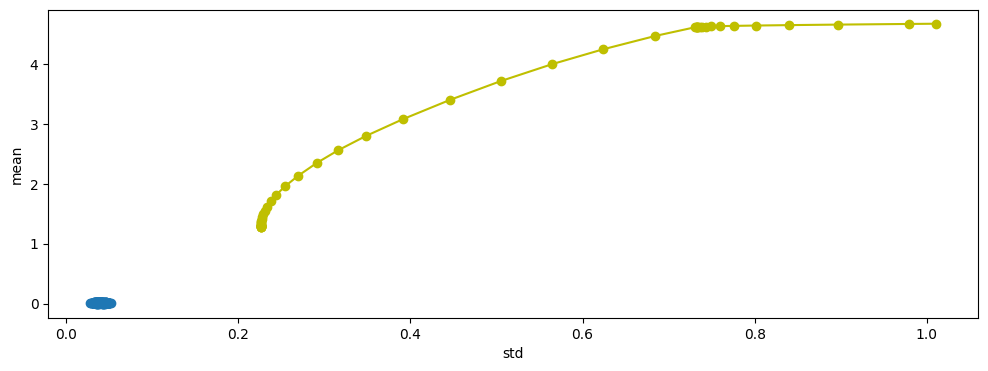

In [43]:
fig = plt.figure(figsize=(12, 4))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

## Rebalancement journalier avec Markowitz

Vous choisissez ici ce que vous fournissez aux fonctions précédemment implémentées.

L'utilisation de `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) est pratiquement obligatoire pour éviter d'incorporer les données futures dans votre système.

Si vous ne respectez pas l'intervalle `2000-01-01`-`2006-01-01` votre solution ne sera pas acceptée.

In [21]:
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2006-01-01')
for x in adjusted_close[(adjusted_close.index>=pd.to_datetime(start))&(adjusted_close.index<pd.to_datetime(stop))].rolling(30):
    if len(x)==30:
        index.append(x.index.max())
        ret = x.pct_change().dropna()
        ret_vec = ret.T.values
        pred = polynomial_regression(x).T.to_numpy()
        weights = pd.Series({"weight_"+a.split('_')[-1]:b[0] for a,b in zip(x.columns,create_markowitz_portfolio(ret_vec, pred)[0][:])})
        weights_df.append(weights)


KeyboardInterrupt: 

Génération de la soumission avec le format requis.

In [ ]:
weights_df_csv = pd.DataFrame(weights_df, index=index)
weights_df_csv.to_csv('sample_submission.csv')
weights_df_csv

,weight_CSCO,weight_DVN,weight_MRO,weight_BA,weight_GILD,weight_MDT,weight_MO,weight_CTRA,weight_MCHP,weight_EIX,weight_BBY,weight_GEN,weight_WBA,weight_DTE,weight_C,weight_T,weight_APH,weight_SYY,weight_MSI,weight_ADM
2000-02-14,2.776742e-07,2.589251e-07,3.080255e-07,2.630514e-07,9.999947e-01,3.308630e-07,3.349363e-07,3.093284e-07,3.294572e-07,2.867575e-07,2.866416e-07,5.618806e-08,3.375081e-07,2.250028e-07,2.746239e-07,3.160698e-07,2.031207e-07,3.346416e-07,3.242836e-07,2.638978e-07
2000-02-15,2.358850e-07,2.703940e-07,2.812232e-07,2.339316e-07,9.999949e-01,3.232456e-07,3.038890e-07,2.829833e-07,2.000411e-07,2.654425e-07,3.247278e-07,5.173531e-08,3.101426e-07,2.221444e-07,2.668163e-07,2.932418e-07,3.252378e-07,3.108424e-07,3.215042e-07,2.652141e-07
2000-02-16,1.004615e-07,2.234184e-07,2.192231e-07,2.086199e-07,9.999966e-01,2.125045e-07,2.244085e-07,2.203001e-07,2.348882e-08,2.125886e-07,2.211243e-07,2.791531e-08,1.157069e-07,2.098983e-07,2.240306e-07,2.246649e-07,9.877009e-08,2.228101e-07,2.025468e-07,2.212787e-07
2000-02-17,1.119751e-07,9.839609e-08,1.333182e-07,1.206692e-07,1.740899e-06,1.270904e-07,1.351725e-07,1.342417e-07,2.244935e-08,1.301623e-07,1.294135e-07,1.949443e-06,8.656057e-08,1.305839e-07,1.312618e-07,1.266821e-07,9.999943e-01,1.315844e-07,1.211820e-07,1.313864e-07
2000-02-18,3.717531e-07,3.900608e-07,3.431387e-07,2.696633e-07,1.009587e-07,2.313659e-07,2.971594e-07,2.896616e-07,3.716614e-07,2.885224e-07,2.931374e-07,3.965581e-07,3.532635e-07,3.020412e-07,3.312614e-07,2.639239e-07,9.999941e-01,3.672365e-07,3.162181e-07,3.436756e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-23,9.069647e-08,9.711146e-08,9.634543e-08,7.890101e-08,1.121613e-07,9.999958e-01,7.888294e-07,1.973729e-06,7.490913e-08,9.628768e-08,5.216962e-08,6.773936e-08,8.808683e-08,6.540083e-08,6.700807e-08,9.609331e-08,9.658834e-08,8.456876e-08,9.008780e-08,8.381465e-08
2005-12-27,2.514016e-09,3.019492e-09,4.906591e-09,4.904243e-09,2.035554e-08,5.593997e-09,8.697397e-09,6.399784e-05,2.424937e-09,2.285981e-09,1.824904e-09,1.694682e-09,4.181131e-09,4.864513e-09,5.183192e-09,2.893392e-09,4.539777e-09,4.117253e-09,9.999359e-01,5.068422e-09
2005-12-28,3.413948e-08,4.845482e-08,3.428053e-08,5.838557e-08,8.959435e-06,6.461161e-08,2.335168e-07,3.689929e-08,4.042998e-08,4.222503e-08,3.572503e-08,3.798568e-08,4.510581e-08,1.324429e-07,1.333979e-07,4.336586e-08,3.647636e-08,6.040906e-08,9.999899e-01,5.877261e-08
2005-12-29,2.199499e-08,2.516968e-08,1.902649e-08,3.573202e-08,1.354047e-06,8.050811e-08,1.149789e-07,1.913139e-08,1.515227e-07,2.571760e-08,4.545543e-08,2.105343e-08,2.228044e-08,8.148860e-08,4.907674e-08,4.118478e-08,1.903917e-08,4.981401e-08,9.999978e-01,3.741902e-08


## Evaluation

In [ ]:
prices_df = adjusted_close.loc[weights_df_csv.index] #On drop encore une fois le premier actif
returns_df = prices_df.shift(-1)/prices_df


In [ ]:
bmrk = pd.read_csv(ROOT+'series/benchmark/SPY_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


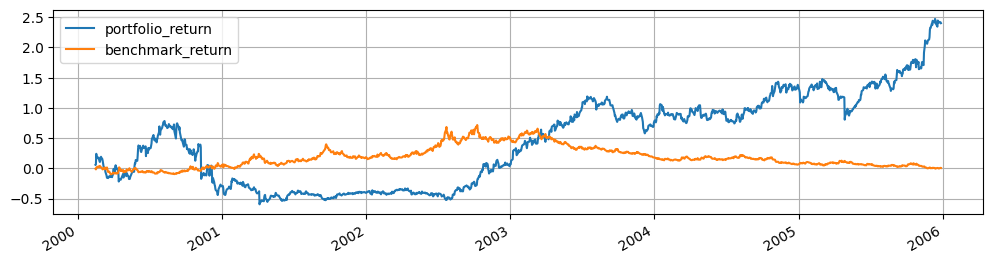

In [ ]:
porfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df_csv.values, columns=weights_df_csv.columns, index=weights_df_csv.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = porfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


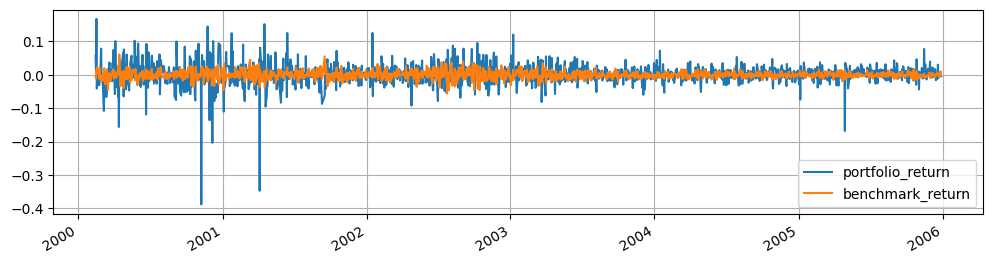

In [ ]:
daily_returns.plot(figsize=(12,3))
plt.grid()


In [ ]:
cov_matrix = daily_returns.cov()
beta = cov_matrix['portfolio_return']['benchmark_return']/cov_matrix['benchmark_return']['benchmark_return']
beta


-0.03223017631005717

In [ ]:
us10bond = pd.read_csv(ROOT+'series/additional_data/us_10ybond_yield.csv',index_col=0)
us10bond.index = pd.to_datetime(us10bond.index)

usCPI = pd.read_csv(ROOT+'series/additional_data/us_CPI.csv',index_col=0)
usCPI.index = pd.to_datetime(usCPI.index)

cpi_idx = lambda x:usCPI[usCPI.index<=pd.to_datetime(x)].index.max()
cumulative_inflation = lambda a,b:(usCPI.loc[cpi_idx(b)]['CPI']-usCPI.loc[cpi_idx(a)]['CPI'])/usCPI.loc[cpi_idx(a)]['CPI']

# risk free rate = 10y bond yield/inflation
rf = ((1+us10bond[us10bond.index<=start].sort_index()['Yield'].values[-1])/100)/cumulative_inflation(start,stop) - 1

# returns
r = cumulative_returns['portfolio_return'].values[-1]
rm = cumulative_returns['benchmark_return'].values[-1]

alpha = r-rf-beta*(rm-rf)
alpha


2.994240395623215

In [ ]:
rf,r,rm,alpha,beta


(-0.574566782935191,
 2.4009529488459944,
 0.006275954688565788,
 2.994240395623215,
 -0.03223017631005717)

Return over Max Drawdown

In [ ]:
# https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp
max_draw_down = ((cumulative_returns.cummax()-cumulative_returns)).max()
c_return = cumulative_returns.iloc[-1]
c_return/max_draw_down

portfolio_return    1.742504
benchmark_return    0.008708
dtype: float64

# Modèle à facteurs (Fama-French)

Nous allons maintenant explorer un modèle d'évaluation des actifs connu sous le nom de méthode Fama-French. Cette méthode est largement utilisée pour analyser la performance d'un portefeuille d'investissements en prenant en compte plusieurs facteurs de risque, au-delà du simple rendement global du marché. Les trois principaux facteurs étudiés sont la prime de risque liée au marché (Mkt-RF), la prime de taille (SMB, basée sur la capitalisation boursière), et la prime de valeur (HML, basée sur la valorisation des actifs). En comprenant comment ces facteurs influencent les rendements des actifs, les investisseurs peuvent prendre des décisions plus éclairées pour gérer leur portefeuille et évaluer la performance de leurs investissements.

- Papier original (PDF): https://www.bauer.uh.edu/rsusmel/phd/Fama-French_JFE93.pdf
- Résumé investopedia: https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp 

![image.png](./kaggle/input/dt23-test/ff3.png)


Les données utilisées par la librairie "getFamaFrenchFactors" peuvent être directement récupérées à l'addresse suivante : https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [ ]:
# # uncomment to install the library
#pip install getFamaFrenchFactors bs4 html5lib lxml

In [ ]:
import getFamaFrenchFactors as gff

ff3 = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3.index = pd.to_datetime(ff3.date_ff_factors)
ff3 = ff3.iloc[:, 1:]
ff3

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-04-30,0.0061,-0.0335,-0.0004,0.0035
2023-05-31,0.0035,0.0161,-0.0772,0.0036
2023-06-30,0.0646,0.0154,-0.0026,0.0040


In [ ]:
start_FF,stop_FF = pd.to_datetime('2020-12-31'),pd.to_datetime('2023-09-01')
monthly_data = adjusted_close.resample('M').mean()
monthly_adjusted_close = monthly_data[(monthly_data.index>=pd.to_datetime(start_FF))&(monthly_data.index<=pd.to_datetime(stop_FF))]
#month_FF= pd.to_datetime('2023-08-31')
years_2021_2023_FF3 = ff3[(ff3.index>pd.to_datetime(start_FF))&(ff3.index<=pd.to_datetime(stop_FF))]
years_2021_2023_FF3

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2021-01-31,-0.0003,0.0736,0.0301,0.0001
2021-02-28,0.0278,0.0205,0.0715,0.0000
2021-03-31,0.0308,-0.0237,0.0739,0.0000
2021-04-30,0.0493,-0.0319,-0.0095,0.0000
2021-05-31,0.0029,-0.0025,0.0709,0.0000
2021-06-30,0.0275,0.0168,-0.0787,0.0000
2021-07-31,0.0127,-0.0397,-0.0178,0.0000
2021-08-31,0.0291,-0.0042,-0.0015,0.0000
2021-09-30,-0.0437,0.0071,0.0508,0.0000


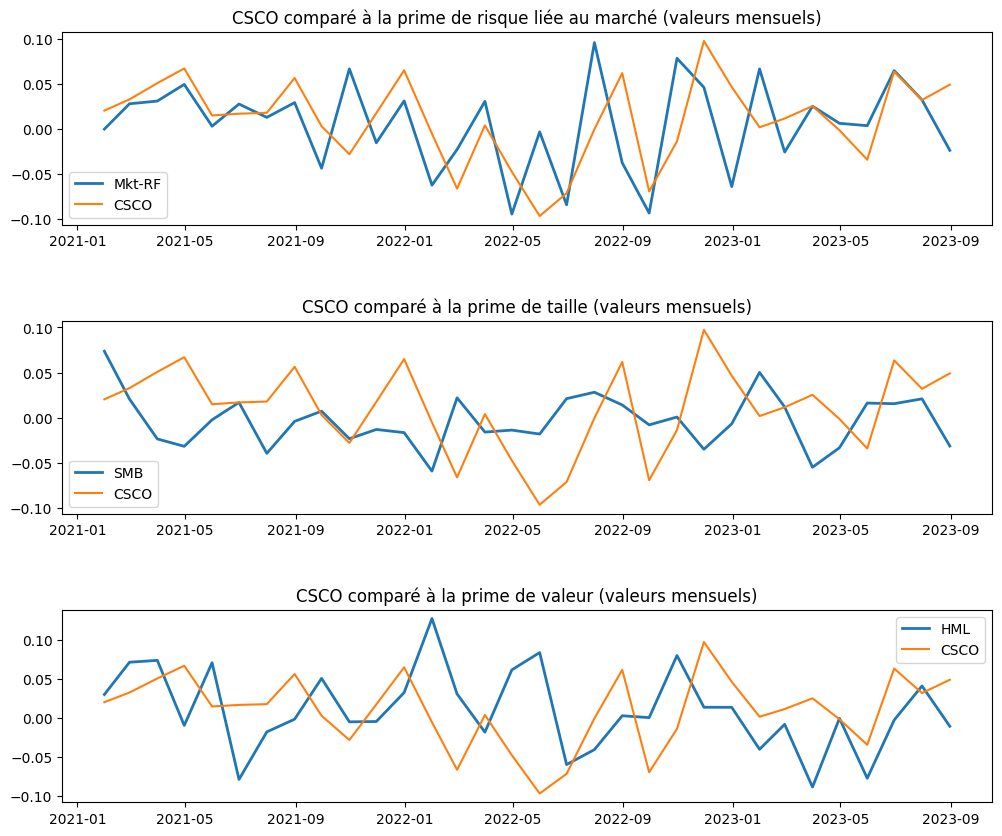

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

csco = monthly_adjusted_close.iloc[:, :1]
csco_ret = csco.pct_change().dropna()

fig, axis = plt.subplots(3, 1,figsize=(12, 10))
axis[0].plot(years_2021_2023_FF3['Mkt-RF'],linewidth=2, label='Mkt-RF')
axis[0].plot(csco_ret, label="CSCO")
axis[0].set_title('CSCO comparé à la prime de risque liée au marché (valeurs mensuels)')
axis[0].legend()

axis[1].plot(years_2021_2023_FF3['SMB'],linewidth=2, label='SMB')
axis[1].plot(csco_ret, label="CSCO")
axis[1].set_title('CSCO comparé à la prime de taille (valeurs mensuels)')
axis[1].legend()

axis[2].plot(years_2021_2023_FF3['HML'],linewidth=2, label='HML')
axis[2].plot(csco_ret, label="CSCO")
axis[2].set_title('CSCO comparé à la prime de valeur (valeurs mensuels)')
axis[2].legend()

plt.subplots_adjust(hspace=0.5)


### Trouvons les valeurs des betas

In [ ]:
import statsmodels.api as sm

def osl_model(y, x):
    model = sm.OLS(y, sm.tools.add_constant(x))
    result = model.fit()
    print(result.summary())
    return result

In [ ]:

y = csco_ret["adjusted_close_CSCO"] - years_2021_2023_FF3["RF"]
x = years_2021_2023_FF3[["Mkt-RF", "SMB", "HML"]]

res = osl_model(y, x)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.115
Date:                Thu, 02 Nov 2023   Prob (F-statistic):              0.121
Time:                        14:51:19   Log-Likelihood:                 57.083
No. Observations:                  32   AIC:                            -106.2
Df Residuals:                      28   BIC:                            -100.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.008      0.709      0.4

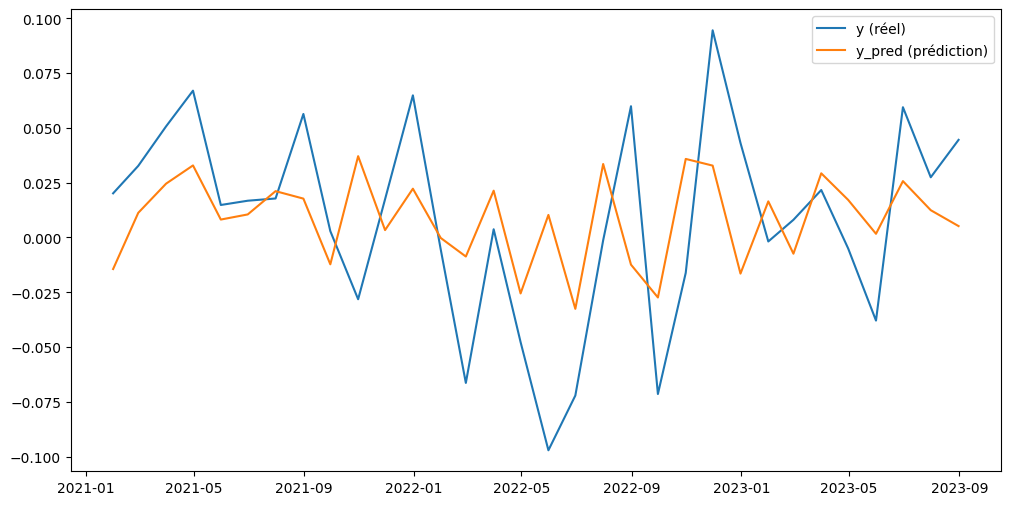

In [ ]:

coefficients = res.params

y_pred = coefficients["const"] + coefficients["Mkt-RF"] * x["Mkt-RF"] + coefficients["SMB"] * x["SMB"] + coefficients["HML"] * x["HML"]

plt.subplots(1, 1, figsize=(12, 6))
plt.plot(y, label="y (réel)")
plt.plot(y_pred, label="y_pred (prédiction)")

plt.legend()
plt.show()


### Calcul du rendement probable de CSCO

In [ ]:


average_FF3 = years_2021_2023_FF3.apply(np.mean)

alpha, ß1, ß2, ß3 = res.params

exp_returns = ß1*average_FF3['Mkt-RF'] + ß2*average_FF3['SMB'] + ß3*average_FF3['HML'] + alpha

Ra = average_FF3['RF'] + exp_returns

In [ ]:
print(f'Le rendement mensuel probable attendus pour CSCO est de :',Ra)
print(f'Le rendement annuel probable attendus pour CSCO est de:',((1 + Ra) ** 12) - 1) 

Le rendement mensuel probable attendus pour CSCO est de : 0.009953246084321651
Le rendement annuel probable attendus pour CSCO est de: 0.12619924710698083
